### Квадратные метры жилья 



Представляем вашему вниманию работу по поиску переменных, которые влияют на цену аренды комнат в Москве

Интро: в этой работе мы хотим изучить, что влияет на цену аренды комнат в Москве, а также в каждом ее отдельном округе. Для этого мы используем данные объявлений с сайта "Циан".

# Содержание:
* [Сбор данных (парсинг)](#Парсинг)
* [Обработтка данных и предварительный](#Анализ-и-обработка-данных)
* [Создание новых признаков](#Создание-новых-признаков)
* [Визуализация и работа с данными](#Визуализация-и-работа-с-данными)
    * [H1. Цена аренды и расстояние до метро](#H1.-Цена-аренды-и-расстояние-до-метро)
    * [H2. Цена аренды и площадь комнаты](#H2.-Цена-аренды-и-площадь-комнаты)
    * [H3-H4. Округ и цена жилья](#H3-H4.-Округ-и-цена-жилья)
    * [H5. Вид из окна и цены](#H5.-Вид-из-окна-и-цены)
    * [H6. Количество комнат и цены](#H6.-Количество-комнат-и-цены)
    * [H7. Размер кухни и цена](#H7.-Размер-кухни-и-цена)
    * [H8. Ремонт и цена](#H8.-Ремонт-и-цена)
    * [H9. Высота квартиры и цена](#H9.-Высота-квартиры-и-цена)
 

## Парсинг

In [2]:
!pip install fake_useragent

In [3]:
""" Импортируем библиотеки для парсинга """
import time # Для прописывания ожидания после каждой итерации цикла, чтобы меньше ловить баны
import requests 
import logging # Для быстрого дебага
from bs4 import BeautifulSoup as bs 
from fake_useragent import UserAgent
from tqdm.notebook import trange #Таймер, чтобы не было скучно смотреть на белый нотбук 
import sys

In [4]:
UserAgent().chrome

'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_4) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.65 Safari/535.11'

In [73]:
logging.basicConfig(filename = 'debug.log',
                    format = u'# %(levelname)-8s [%(asctime)s]  %(message)s',
                    level = logging.DEBUG,
                    encoding = 'utf-8'
                )

In [74]:
def check_IP():
    ip = requests.get('http://checkip.dyndns.org').content
    soup = bs(ip, 'html.parser')
    print(soup.find('body').text)

In [ ]:
response = requests.get(url, headers = {'User-Agent': UserAgent().chrome})

In [75]:
def get_page(p): 
    """ Получаем доступ ко всем предложениям комнат на странице
    
    Сначала заходим на страницу затем формируем список со всеми предложениями на ней.
    
    """
    url = 'https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p={}&region=1&room0=1&type=4'.format(p)
    response = requests.get(url, headers = {'User-Agent': UserAgent().chrome})
    if response.ok == False:
        logging.error('Произошел бан или капча')
        sys.exit()
    tree = bs(response.content, 'html.parser')
    offers = tree.find_all('article', {'class' : '_93444fe79c--container--2pFUD _93444fe79c--cont--1Ddh2'})
    infa = []
    
    for offer in offers:
        """ Собираем всю доступную информцию с превью объявления"""
        try:
            geo = offer.find('div', {'class': '_93444fe79c--labels--1J6M3'}).text
            geo = [j.strip() for j in geo.split(',')] #Возможно требует удаления или переработки
        except:
            geo = ''
        try:
            dtr = offer.find('div', {'class': '_93444fe79c--remoteness--1BnAC'}).text
        except:
            dtr = ''
        try:
            metro = offer.find('a', {'class': '_93444fe79c--link--3ruIo'}).text
        except:
            metro = ''
        try:
            price = offer.find('span', {'data-mark': 'MainPrice'}).text
        except:
            price = ''
        
        """ Внутри каждого блока предложения получаем ссылку на саму комнату"""
        offer_link = offer.find('div', {'data-name' : 'LinkArea'}).find('a').get('href')
        inside_response = requests.get(offer_link, headers = {'User-Agent': UserAgent().chrome})
        if inside_response.ok == False:
            logging.error('Произошел бан или капча')
            sys.exit()
        inside_tree = bs(inside_response.content, 'html.parser')
        offer_info = inside_tree.find('main', {'class': 'a10a3f92e9--offer_card_page--3-GaL'}) 

        """ Получаем доступ ко всем ячейкам со всей короткой информацией по комнате

        Формируем словарь {"Критерий": "Значение"} для последующего удобного обращения для
        занесения в таблицу с общей информацией.

        """
        short_info = {
                            'Этаж' : '',
                            'Кухня': '',
                            'Комната': '',
                            'Построен': ''
                }
        try:
            values = offer_info.find_all('div', {'class': 'a10a3f92e9--info-value--18c8R'})
            titles = offer_info.find_all('div', {'class': 'a10a3f92e9--info-title--2bXM9'})
            for i in range(len(values)):
                short_info[titles[i].text] = values[i].text
        except:
            logging.warning('Null short info in: %s', offer_link)
            pass
        
        """ Получеим информацию из блока с общей информацией о квартире

        Аналогичично создадим словарь {"Критерий": "Значение"} 

        """
        general_info = {
                                'Всего комнат в квартире': '',
                                'Комнат в аренду': '',
                                'Планировка':'',
                                'Высота потолков': '',
                                'Санузел': '',
                                'Ванная комната': '',
                                'Ремонт': '',
                                'Вид из окон': ''
            
            }
        
        try:
            general_titles = offer_info.find_all('span', {'class': 'a10a3f92e9--name--3bt8k'})
            general_values = offer_info.find_all('span', {'class': 'a10a3f92e9--value--3Ftu5'})
            for i in range(len(general_values)):
                general_info[general_titles[i].text] = general_values[i].text
        except:
            logging.warning('Null general info in: %s', offer_link)
            pass

            
        """ Сохранение информации
        
        Заргужаем информацию по каждому предложению в словарь, чтобы потом их преобразовать
        в таблицу данных.
        
        """
        try:
            infa.append(
                    {
                        'distance to metro' : dtr,
                        'city' : geo[0],
                        'district' : geo[1],
                        'region' : geo [2],
                        'metro' : metro,
                        'adress' : (geo[4] + ' ' + geo[5]),
                        'price' : price,
                        'floor' : short_info['Этаж'],
                        'kitchen size': short_info['Кухня'],
                        'room size' : short_info['Комната'],
                        'age of construction' : short_info['Построен'],
                        'rooms in flat': general_info['Всего комнат в квартире'],
                        'rooms to rent': general_info['Комнат в аренду'],
                        'apartment layout': general_info['Планировка'],
                        'ceiling height': general_info['Высота потолков'],
                        'restroom': general_info['Санузел'],
                        'bathroom': general_info['Ванная комната'],
                        'remont': general_info['Ремонт'],
                        'window view': general_info['Вид из окон'],
                    }
                )
        except:
            pass
        time.sleep(3)
    return infa

In [76]:
"""Сбор данных со всех страниц с объявлениями

Будем собирать до тех пор пока не наберем пока 600 объявлений

"""
infa = []
for p in trange(1,54): 
    logging.info('Начал сбор данных на %s странице', p)
    infa.extend(get_page(p))
    logging.info('Закончил сбор данных на %s странице', p)
    if len(infa) > 600:
        logging.info('Все данные успешно собраны!!! (Можно отпраздновать если это высветилось)')
        break
    time.sleep(2)

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(infa)
print(df.shape)
df.sample(15)

In [1]:
""" Для безопасности выгружаем таблицу полученную после парсинга циана """
df.to_csv("cian_df")

NameError: name 'df' is not defined

## Анализ и обработка данных

In [1]:
import pandas as pd
import numpy as np

In [78]:
df = pd.read_csv('cian_df')

Давайте предварительно изучим наши данные.

In [79]:
print(df.shape)
df.tail(5)

(620, 20)


,Unnamed: 0,distance to metro,city,district,region,metro,adress,price,floor,kitchen size,room size,age of construction,rooms in flat,rooms to rent,apartment layout,ceiling height,restroom,bathroom,remont,window view
615,615,7 минут пешком,Москва,ЦАО,р-н Замоскворечье,Павелецкая,1-й Новокузнецкий переулок 13,17 000 ₽/мес.,5 из 5,9 м²,19 м²,1952.0,3.0,1.0,Изолированная,3 м,1 раздельный,Есть,Без ремонта,NaN
616,616,4 минуты пешком,Москва,ЮЗАО,р-н Южное Бутово,Бутово,Старонародная улица 4,17 000 ₽/мес.,5 из 14,10 м²,16 м²,1995.0,2.0,1.0,Изолированная,"2,64 м",1 раздельный,Есть,Евроремонт,Во двор
617,617,5 минут пешком,Москва,ЮАО,р-н Царицыно,Царицыно,Каспийская улица 28К2,17 000 ₽/мес.,5 из 5,6 м²,19 м²,1965.0,2.0,1.0,Изолированная,"2,48 м",1 раздельный,Есть,Косметический,Во двор
618,618,11 минут пешком,Москва,СВАО,р-н Отрадное,Дегунино,Алтуфьевское шоссе 24,17 000 ₽/мес.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619,619,6 минут пешком,Москва,ЮАО,р-н Орехово-Борисово Северное,Орехово,Шипиловский проезд 43К4,17 000 ₽/мес.,5 из 16,10 м²,24 м²,1975.0,3.0,1.0,Изолированная,"2,48 м",1 раздельный,Есть,Косметический,Во двор


Посмотрим, как дела с пропусками

In [80]:
df.isnull().sum()

Unnamed: 0               0
distance to metro        0
city                     0
district                 0
region                   0
metro                    0
adress                   0
price                    0
floor                   12
kitchen size            35
room size               12
age of construction    154
rooms in flat           16
rooms to rent           34
apartment layout       166
ceiling height         312
restroom               148
bathroom               154
remont                  66
window view            272
dtype: int64

Получается грустно - много пропущенных значений. Нами было принято волевое решение заполнить средними (модой/медианой) пропущенные значения во всех столбцах, кроме, age of construction, apartment layout, ceiling height, window view. С этими столбцами мы будем работать с осторожностью

Далее мы хотим преобразовать наши столбцы. Почистим их от лишних слов и разобьем один на две переменные.

In [81]:
df['floor of flat'], df['height']  = df['floor'].str.split(' из ', 1).str
df['price_cl'], df['to drop']  = df['price'].str.split('₽', 1).str
df['kitchen size cl'], df['to drop 1']  = df['kitchen size'].str.split('м', 1).str
df['room size cl'], df['to drop 2']  = df['room size'].str.split('м', 1).str
df['ceiling height'], df['to drop 4'] = df['ceiling height'].str.split(' ', 1).str

<ipython-input-81-625fa3157019>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['floor of flat'], df['height']  = df['floor'].str.split(' из ', 1).str
<ipython-input-81-625fa3157019>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['price_cl'], df['to drop']  = df['price'].str.split('₽', 1).str
<ipython-input-81-625fa3157019>:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['kitchen size cl'], df['to drop 1']  = df['kitchen size'].str.split('м', 1).str
<ipython-input-81-625fa3157019>:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['room size cl'], df['to drop 2']  = df['room size'].str.split('м', 1).str
<ipython-input-81-625fa3157019>:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['ceiling height'], df['to drop 4'] = df['ceiling height'].str.spli

Время до квартиры и способ передвижения (type of way)

In [82]:
df['to metro'], df['type of way']  = df['distance to metro'].str.split(' ', 1).str

<ipython-input-82-2d7ce99a7cd6>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['to metro'], df['type of way']  = df['distance to metro'].str.split(' ', 1).str


In [83]:
df['to drop 5'], df['type of way'] = df['type of way'].str.split(' ', 1).str

<ipython-input-83-4257c83d3fe7>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['to drop 5'], df['type of way'] = df['type of way'].str.split(' ', 1).str


Удаляем лишние столбцы

In [84]:
del df['to drop 5']
del df['distance to metro']

In [85]:
del df['price']
del df['to drop']
del df['floor']
del df['to drop 1']
del df['to drop 2']
del df['kitchen size']
del df['room size']
del df['to drop 4']

Приведем все к нужному формату (численному)

In [86]:
df['price'], df['to drop 2'] = df['price_cl'].str.split(' ', 1).str
df['price'] = df['price'].apply(pd.to_numeric) 
df['price'] = df['price']*1000

<ipython-input-86-570e0a548b43>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df['price'], df['to drop 2'] = df['price_cl'].str.split(' ', 1).str


In [87]:
df['kitchen size cl'] = df['kitchen size cl'].str.strip()
df['kitchen size'] = df['kitchen size cl'].str.replace(',', '.')
df['room size cl'] = df['room size cl'].str.strip()
df['room size'] = df['room size cl'].str.replace(',', '.')
df['ceiling height'] = df['ceiling height'].str.replace(',', '.')
df['ceiling height'] = df['ceiling height'].str.replace(',', '.')

In [88]:
df['kitchen size'] = df['kitchen size'].apply(pd.to_numeric) 
df['room size'] = df['room size'].apply(pd.to_numeric)
df['floor of flat'] = df['floor of flat'].apply(pd.to_numeric) 
df['height'] = df['height'].apply(pd.to_numeric)  
df['ceiling height'] = df['ceiling height'].apply(pd.to_numeric) 
df['to metro'] = df['to metro'].apply(pd.to_numeric) 

In [89]:
del df['price_cl']
del df['to drop 2']
del df ['Unnamed: 0']
del df['kitchen size cl']
del df['room size cl']

In [90]:
df.rename(columns = {'age of construction': 'age_of_construction',
                     'rooms in flat': 'rooms_in_flat',
                     'rooms to rent': 'rooms_to_rent',
                     'apartment layout': 'apartment_layout',
                     'ceiling height': 'ceiling_height',
                     'window view': 'window_view',
                     'floor of flat': 'floor_of_flat',
                     'to metro': 'to_metro',
                     'type of way': 'type_of_way',
                     'kitchen size': 'kitchen_size',
                     'room size': 'room_size',
                     'building age': 'building_age',
                     'share in flat': 'share_in_flat',
                     'remont scale': 'remont_scale',
                     'price per square': 'price_per_square'}, inplace = True)

In [91]:
df.isnull().sum()

city                     0
district                 0
region                   0
metro                    0
adress                   0
age_of_construction    154
rooms_in_flat           16
rooms_to_rent           34
apartment_layout       166
ceiling_height         312
restroom               148
bathroom               154
remont                  66
window_view            272
floor_of_flat           12
height                  12
to_metro                 0
type_of_way              0
price                    0
kitchen_size            35
room_size               12
dtype: int64

**Мы решили сделать следующее**: 1) лидеров по пропускам **(apartment layout, ceiling height, restroom, bathroom и window view)** мы просто оставим как есть, и если и будем использовать в анализе, то с оговоркой, что выводы применимы только к части выборки. 2) пропуски в значениях дискретных переменных **age of construction, rooms in flat, rooms to rent, remont, floor of flat, height** мы заполним модой (из-за дискретности) 3) пропуски в значениях интервальных переменных **kitchen size, room size** мы запоним средним

#### Напишем функцию заполнения данных модой 

In [92]:
def mode_fill(df, criteria):
    mode = df[criteria].mode()[0]
    df[criteria] = df[criteria].fillna(mode)
    return df[criteria]

Заполним пропуски необходимых нам столбцов модой

In [93]:
df['age_of_construction'] = mode_fill(df, 'age_of_construction')
df['rooms_in_flat'] = mode_fill(df, 'rooms_in_flat')
df['rooms_to_rent'] = mode_fill(df, 'rooms_to_rent')
df['remont'] = mode_fill(df, 'remont')
df['height'] = mode_fill(df, 'height')
df['floor_of_flat'] = mode_fill(df, 'floor_of_flat')

#### Заполним пропуским средним значением по столбцу

In [94]:
df['kitchen_size'] = df['kitchen_size'].fillna(df['kitchen_size'].mean())
df['room_size'] = df['room_size'].fillna(df['room_size'].mean())

Мы заполнили прпуски во всех столбцах которые хотели и теперь можно приступить к визуализации данных и валидации наших гипотез

In [95]:
df.isnull().sum()

city                     0
district                 0
region                   0
metro                    0
adress                   0
age_of_construction      0
rooms_in_flat            0
rooms_to_rent            0
apartment_layout       166
ceiling_height         312
restroom               148
bathroom               154
remont                   0
window_view            272
floor_of_flat            0
height                   0
to_metro                 0
type_of_way              0
price                    0
kitchen_size             0
room_size                0
dtype: int64

In [2]:
!pip install matplotlib

In [3]:
import matplotlib.pyplot as plt

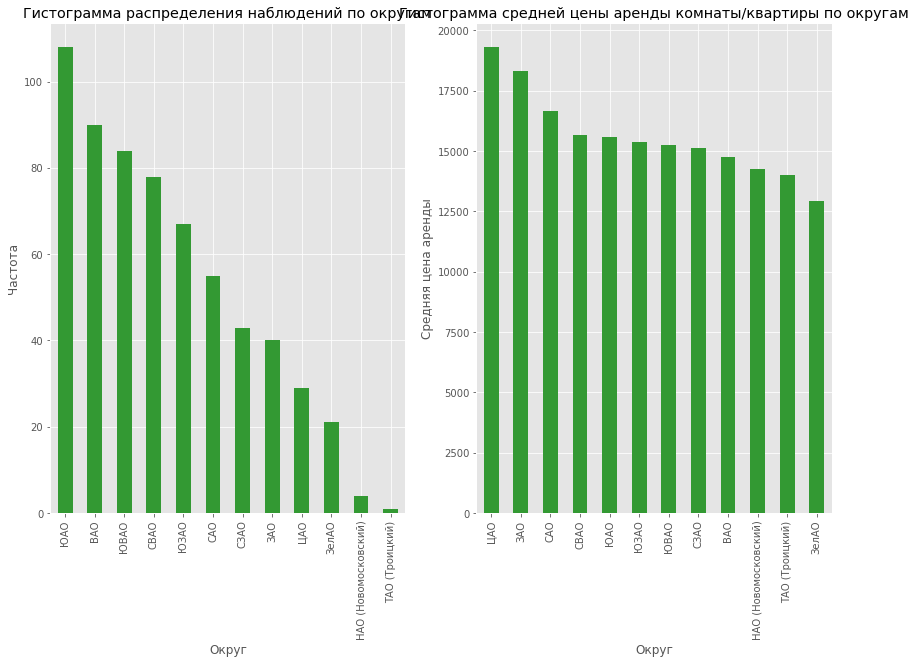

In [97]:
fig, ax = plt.subplots(1, 2, figsize = (14,9))
gb_district = df.groupby('district').adress.count().sort_values(ascending = False)
gb_district.plot(kind = 'bar', ax = ax[0], color = '#339933')
ax[0].set_title("Гистограмма распределения наблюдений по округам")
ax[0].set_xlabel("Округ", fontsize = 12)
ax[0].set_ylabel("Частота", fontsize = 12)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

gb2_district = df.groupby('district').price.mean().sort_values(ascending = False)
gb2_district.plot(kind = 'bar', ax = ax[1], color = '#339933')
ax[1].set_title("Гистограмма средней цены аренды комнаты/квартиры по округам")
ax[1].set_xlabel("Округ", fontsize = 12)
ax[1].set_ylabel("Средняя цена аренды", fontsize = 12)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False);

По полученным данным видно, что больше всего комнат сдается в ЮАО и совсем немного в ТАО и НАО. По цене самым дорогим округом является ЗАО, а самым дешевым ЗелАО

## Создание новых признаков
Мы думаем, что нашей табличке не хватает несколько переменных. А именно - цены аренды на квадратный метр **(price per square)**, возраста здания **(age of buiding)**, взвешенного времени до метро **(to metro)** - хотим учесть разницу в способе передвижения, долю в квартире (**share in flat)**, а также немного поиграть с состоянием квартиры - сделаем псевдоинтервальную шкалу на основе переменной remont.

**Время до метро**. Мы узнали, что средняя скорость движения на наземном общественном транспорте в Москве - 15, 7 км/ч (к сожалению, новее 2018 года данных нет https://tass.ru/moskva/5929571). Средняя скорость пешего шага - 4 км/ч. Получается, что время на транспорте необходимо умножить на **3. 925**, чтобы учесть разницу в способе передвижения.

In [98]:
for i in range(620):
    if df['type_of_way'][i] == 'на транспорте':
        df['to_metro'][i] = df['to_metro'][i] * 3.925

<ipython-input-98-6fbadb3c9f3d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['to_metro'][i] = df['to_metro'][i] * 3.925


**Возраст здания**

In [99]:
df['building_age'] = 2021 - df['age_of_construction'] 

**Доля в квартире** 

In [100]:
df['share_in_flat'] = df['rooms_to_rent']/df['rooms_in_flat'] 

**Ремонт.** Мы предполагаем, что квартиры с дизайнерским ремонтом - самые крутые, с евроремонтом - чуть похуже, с косметическим - еще хуже, а без ремонта совсем плохие.

In [101]:
df['remont'].value_counts()

Косметический    534
Евроремонт        78
Без ремонта        7
Дизайнерский       1
Name: remont, dtype: int64

In [102]:
df['remont_scale'] = str

In [103]:
for i in range(620):
    if df['remont'][i] == 'Без ремонта':
        df['remont_scale'][i] = 0
    elif df['remont'][i] == 'Косметический':
        df['remont_scale'][i] = 1
    elif df['remont'][i] == 'Евроремонт':
        df['remont_scale'][i] = 2
    elif df['remont'][i] == 'Дизайнерский':
        df['remont_scale'][i] = 3
    else:
        df['remont_scale'][i] = df['remont'][i]

<ipython-input-103-c726a561f398>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['remont_scale'][i] = 1
<ipython-input-103-c726a561f398>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['remont_scale'][i] = 2
<ipython-input-103-c726a561f398>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['remont_scale'][i] = 0
<ipython-input-103-c726a561f398>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

**Вид из окна**

In [104]:
df['window_view'].value_counts()

Во двор            297
На улицу и двор     26
На улицу            25
Name: window_view, dtype: int64

In [105]:
for i in range(620):
    if df['window_view'][i] == 'На улицу':
        df['window_view'][i] = 0
    elif df['window_view'][i] == 'На улицу и двор':
        df['window_view'][i] = 1
    elif df['window_view'][i] == 'Во двор':
        df['window_view'][i] = 2

<ipython-input-105-5b8a80f721c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['window_view'][i] = 0
<ipython-input-105-5b8a80f721c5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['window_view'][i] = 1
<ipython-input-105-5b8a80f721c5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['window_view'][i] = 2


In [106]:
df['window_view'] = df['window_view'].apply(pd.to_numeric) 

**Цена аренды на квадратный метр**

In [107]:
df['price_per_square'] = df['price']/df['room_size'] 

In [108]:
df

,city,district,region,metro,adress,age_of_construction,rooms_in_flat,rooms_to_rent,apartment_layout,ceiling_height,...,height,to_metro,type_of_way,price,kitchen_size,room_size,building_age,share_in_flat,remont_scale,price_per_square
0,Москва,ЮЗАО,р-н Коньково,Коньково,улица Островитянова 35А,1978.0,2.0,1.0,Изолированная,NaN,...,17.0,7,пешком,21000,12.000000,14.000000,43.0,0.500000,1,1500.000000
1,Москва,СВАО,р-н Отрадное,Владыкино,Алтуфьевское шоссе 2,1990.0,2.0,1.0,Изолированная,2.70,...,16.0,3,пешком,30000,8.638803,20.000000,31.0,0.500000,2,1500.000000
2,Москва,ЮВАО,р-н Лефортово,Авиамоторная,Авиамоторная улица 35,1969.0,3.0,1.0,NaN,NaN,...,5.0,5,пешком,30000,8.000000,15.000000,52.0,0.333333,2,2000.000000
3,Москва,ЮАО,р-н Даниловский,Павелецкая,Павелецкая набережная 2С2,1999.0,6.0,1.0,Изолированная,3.00,...,4.0,15,пешком,20000,15.000000,10.000000,22.0,0.166667,1,2000.000000
4,Москва,ЮЗАО,р-н Теплый Стан,Теплый Стан,улица Теплый Стан 5К3,1975.0,2.0,1.0,Изолированная,2.48,...,16.0,5,пешком,18000,7.000000,15.000000,46.0,0.500000,1,1200.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,Москва,ЦАО,р-н Замоскворечье,Павелецкая,1-й Новокузнецкий переулок 13,1952.0,3.0,1.0,Изолированная,3.00,...,5.0,7,пешком,17000,9.000000,19.000000,69.0,0.333333,0,894.736842
616,Москва,ЮЗАО,р-н Южное Бутово,Бутово,Старонародная улица 4,1995.0,2.0,1.0,Изолированная,2.64,...,14.0,4,пешком,17000,10.000000,16.000000,26.0,0.500000,2,1062.500000
617,Москва,ЮАО,р-н Царицыно,Царицыно,Каспийская улица 28К2,1965.0,2.0,1.0,Изолированная,2.48,...,5.0,5,пешком,17000,6.000000,19.000000,56.0,0.500000,1,894.736842
618,Москва,СВАО,р-н Отрадное,Дегунино,Алтуфьевское шоссе 24,1969.0,3.0,1.0,NaN,NaN,...,9.0,11,пешком,17000,8.638803,15.559046,52.0,0.333333,1,1092.611973


## Визуализация и работа с данными

In [109]:
import seaborn as sns 

Построим ящик с усами и оценим если ли выбросы в объявлениях по цене 

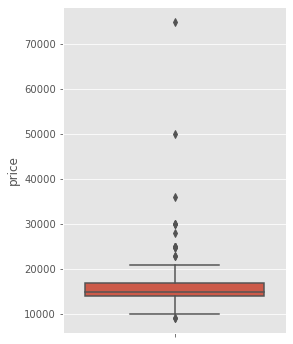

In [110]:
plt.show()
plt.figure(figsize=(4,6))
sns.boxplot(y = df['price'], data = df);

Как видно, выбросов не много, значит их можно оставить

Построим тепловую карту, чтобы предварительно понять, где можно искать интересные взаимосвязи. Также мы хотим построить тепловую карту для каждого округа в разрезе, чтобы понять, есть ли в каждом отдельном округе какие-либо особенности. Но для этого мы должны быть уверены, что выборка по отдельному району наполнена (> 30 наблюдений). 

In [111]:
df['district'].value_counts()

ЮАО                     108
ВАО                      90
ЮВАО                     84
СВАО                     78
ЮЗАО                     67
САО                      55
СЗАО                     43
ЗАО                      40
ЦАО                      29
ЗелАО                    21
НАО (Новомосковский)      4
ТАО (Троицкий)            1
Name: district, dtype: int64

Получается, что если для ЦАО и всех вышестоящих округов построить корреляции можно, то ЗелАО, НАО и ТАО стоит исключить из анализа

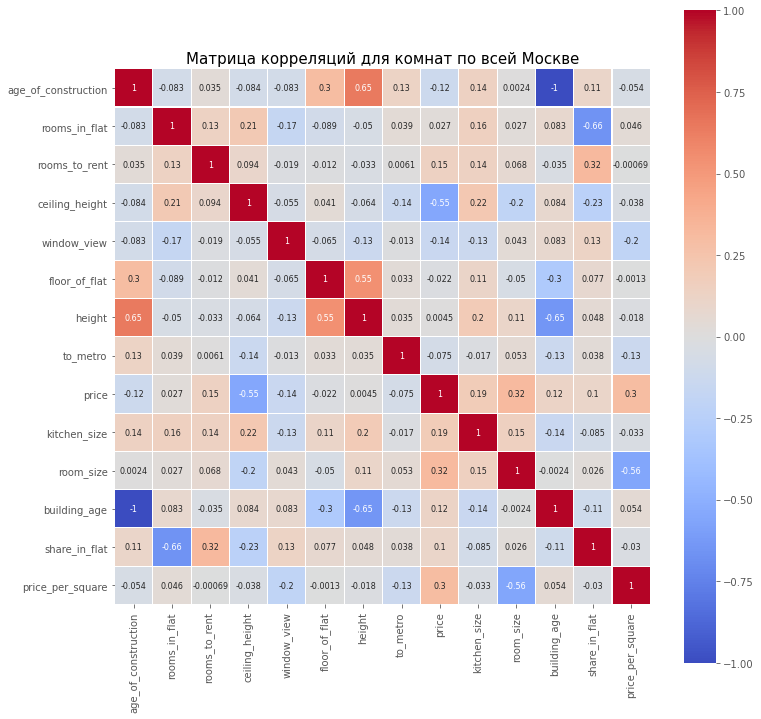

In [112]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), cmap='coolwarm',
            vmin=-1, vmax=1, 
            square=True,
            linewidths=0.1,annot_kws={"fontsize":8},
            annot=True);

plt.title('Матрица корреляций для комнат по всей Москве', fontsize = 15);

Что мы видим в этой таблице? Во-первых, в целом по Москве **высота потолков (удивительно) сильно отрицательно влияет на стоимость аренды**, но на аренду на кв/м почти не влияет. Также, положительно влияют на цену аренды **размер кухни и размер комнаты**. 
Дополнительно можно сделать вывод, что **чем позднее здание было построено, тем оно выше**.
Остальные переменные близки к нулю, значит корреляция незначительна - такая же ситуация и с ценой аренды на кв/м.

In [113]:
def corr_district(district, df):
    plt.figure(figsize = (12,12))
    sns.heatmap(df[df['district'] == district].corr(), 
                cmap = 'coolwarm',
                vmin = -1, vmax = 1, 
                square = True,
                linewidths = 0.1,annot_kws = {"fontsize":8},
                annot = True);
    title = 'Матрица корреляций для комнат в ' + district
    plt.title(title, fontsize = 15)

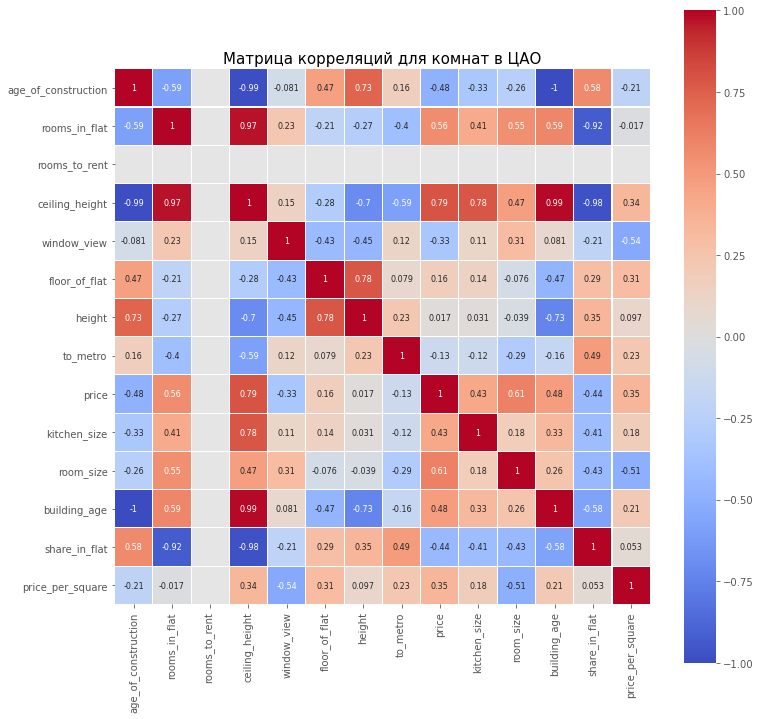

In [114]:
corr_district('ЦАО', df)

В ЦАО ситуация интереснее: **сильная положительная связь наблюдается с возрастом здания, комнатами в квартире и высотой потолков (в целом по Москве она наоборот, отрицательная)**. Получается, арендаторы центра больше хотят жить в дореволюционных коммуналках, чем в респектабельных двушках в новостройках. Также, в ЦАО очень **ценят большие кухни и комнаты**.

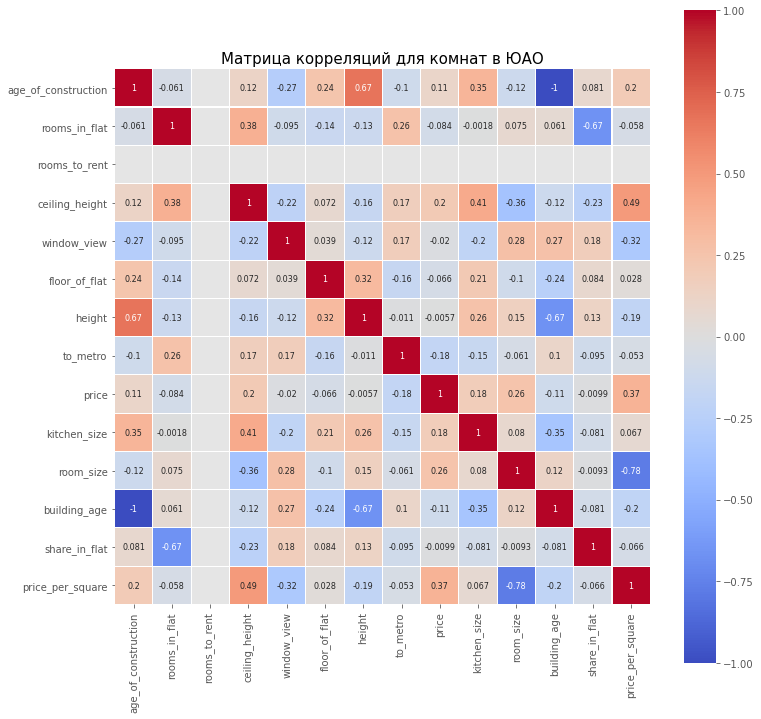

In [115]:
corr_district('ЮАО', df)

Удивительно: **арендодателям в ЮАО безразличны почти все отобранные нами параметры связанные с ценой**. Есть только слабая положительная связь цены аренды с высотой полотков, размером кухни и комнаты, но эта связь присутствует в любом другом округе

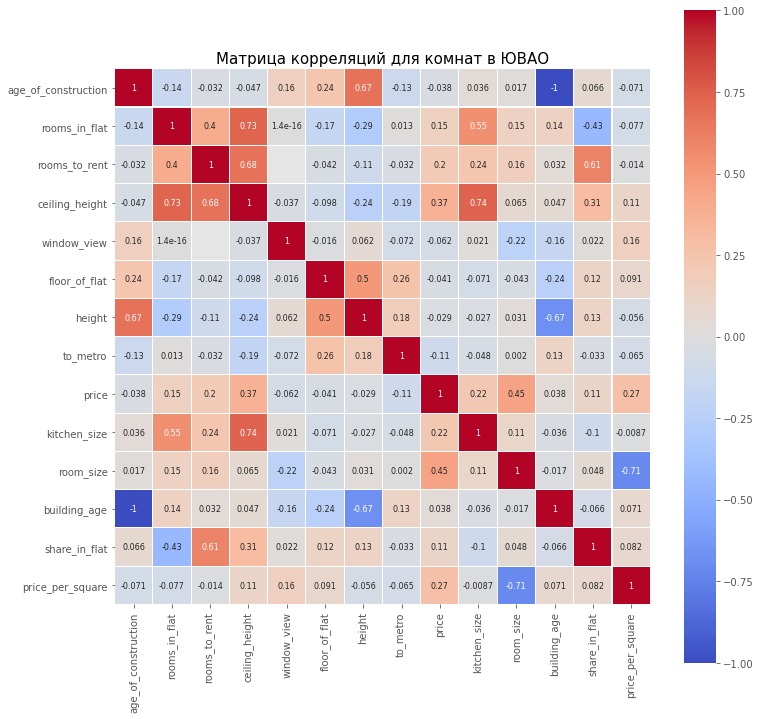

In [116]:
corr_district('ЮВАО', df)

В ЮВАО тоже ценят простор в кухнях и в комнатах, а также потолки. И немного больше любят большие квартиры - **цена аренды имеет слабую положительную связь с количеством комнат в квартире**.

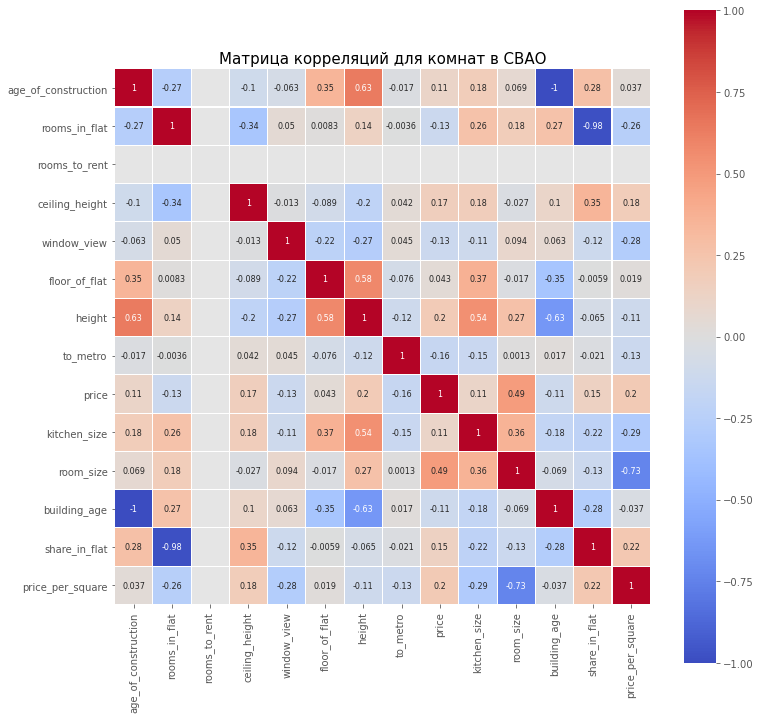

In [117]:
corr_district('СВАО', df)

Жителям СВАО почему-то почти безразличен размер кухни, но им стандартно нравятся высокие потолки и большие комнаты (сильно). Интересно, что здесь мы впервые обнаруживаем **положительную связь цены с этажом квартиры**.

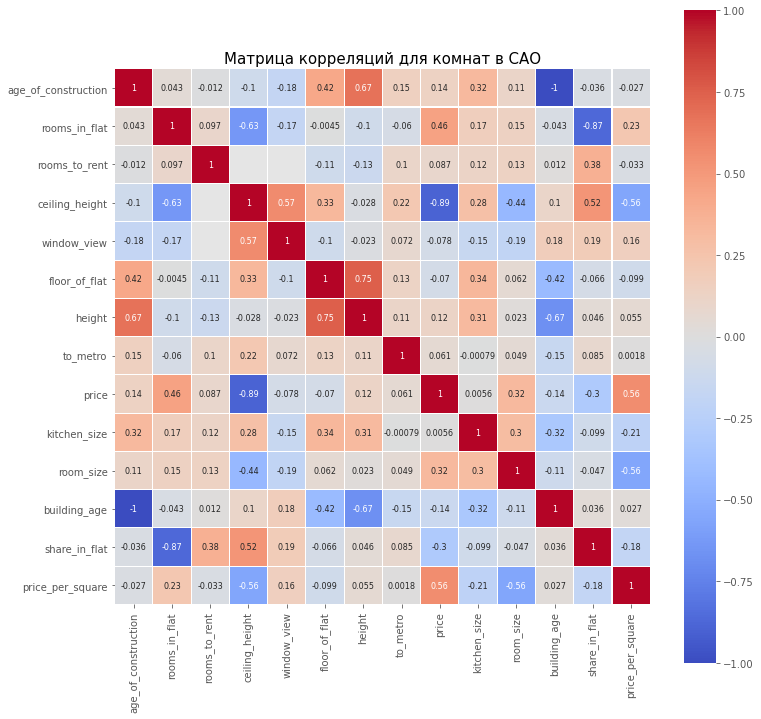

In [118]:
corr_district('САО', df)

С жителями САО что-то странное - **они очень не любят высокие потолки и им безразличны большие кухни (наверное, устали от сталинок)**. Зато, **арендаторы в САО любят квартиры с большим количество комнат и скорее предпочитают более новое жилье**.

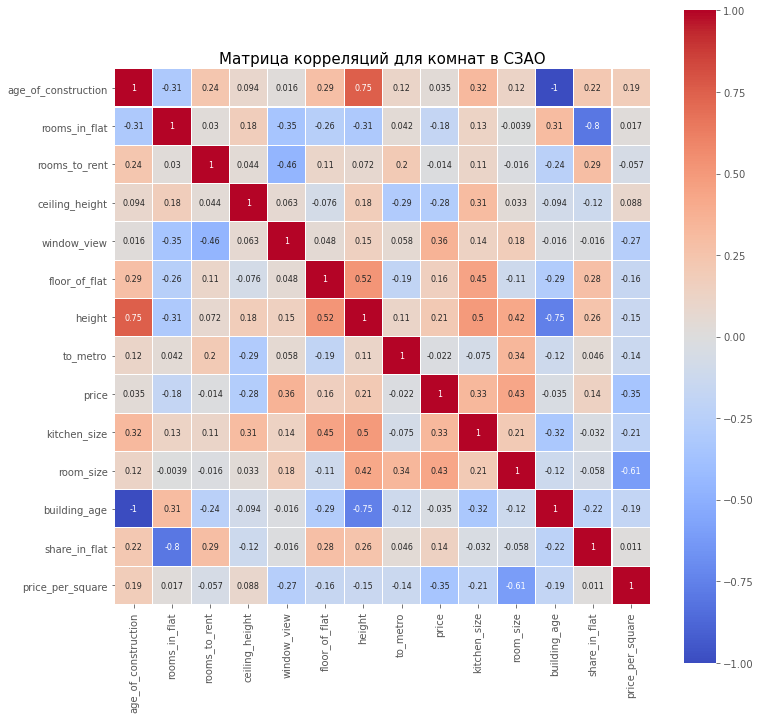

In [119]:
corr_district('СЗАО', df)

В СЗАО тоже не любят высокие потолки (наверное, какие-то северные традиции - больше отапливать зимой), зато любят высокие этажи, здания, большие кухни и комнаты. Интересно, что **по портрету типовая новостройка больше всего подходит жителям СЗАО**

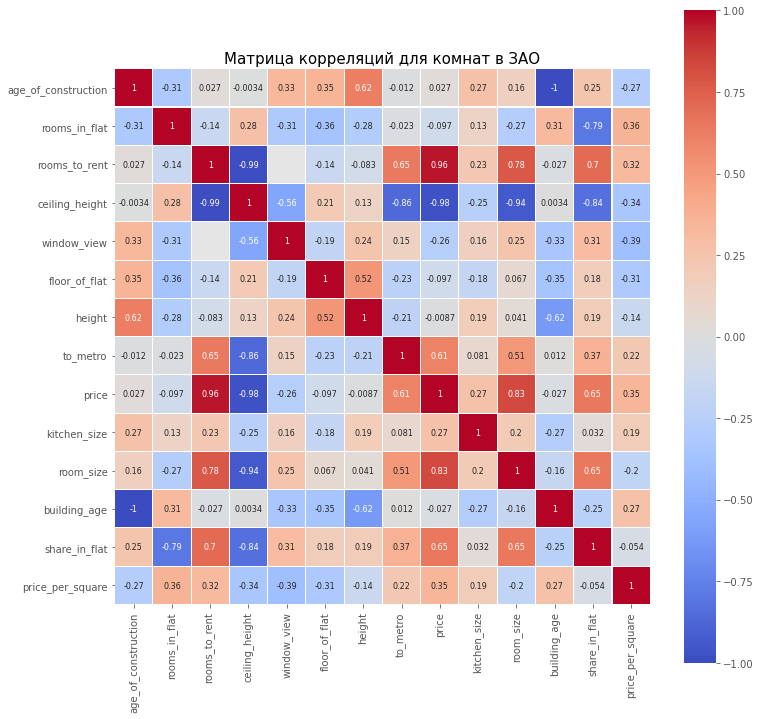

In [120]:
corr_district('ЗАО', df)

ЗАО больше всех ценит большие комнаты и большие квартиры. А еще, **это единственный округ где оценивают время до метро - но тоже интересно, чем дольше добираться до метро, тем выше цена**. А еще, в ЗАО очень не любят высокие потолки.

Таким образом, мы наметили, что нам изучать - корреляции мы посмотрели, теперь проверим это в реальных числах и посмотрим на графики. А главное поняли, что московские округа - очень разные, поэтому стоит изучать московский рынок аренды комнат в разрезе. Кроме того, мы совсем не уделили внимание номинальным переменным.

In [121]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

### H1. Цена аренды и расстояние до метро

**H1: Цена аренды и цена аренды на квадратный метр отрицательно связаны с расстоянием до метро**

In [122]:
df.groupby('district').price.corr(df['to_metro']).sort_values(ascending = False)

C:\Users\clank\anaconda3\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\clank\anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


district
ЗАО                     0.608832
САО                     0.061262
СЗАО                   -0.022459
ЮВАО                   -0.109364
ЦАО                    -0.129689
НАО (Новомосковский)   -0.138053
ЗелАО                  -0.153667
ВАО                    -0.154238
СВАО                   -0.164042
ЮАО                    -0.183272
ЮЗАО                   -0.340144
ТАО (Троицкий)               NaN
Name: price, dtype: float64

Получилось так, что по Москве обратная свзь действительно есть, но она крайне незначительна. В остальных округах связь очень близка к нулю, поэтому она тоже незначительно. Однако есть интересный случай: в ЗАОсо средней теснотой связи можно утвержать, что чем больше расстояние до метро тем больше цена, а в ЮЗАО наоборот есть незначительная обратная свзяь

### H2. Цена аренды и площадь комнаты

**H2: Цена аренды положительно коррелирует с площадью комнаты**


In [123]:
df.groupby('district').price.corr(df['room_size']).sort_values(ascending = False)

district
ЗАО                     0.830187
ЦАО                     0.610984
СВАО                    0.485982
ЮВАО                    0.448260
СЗАО                    0.430290
ЗелАО                   0.420852
ЮЗАО                    0.358557
НАО (Новомосковский)    0.349927
САО                     0.324847
ВАО                     0.277883
ЮАО                     0.255469
ТАО (Троицкий)               NaN
Name: price, dtype: float64

В среднем по Моксве можно заметить слабую связь между двумя этими факторами, однако есть регионы, где эта связь сильнее. Например, ЦАО, ЮВАО, СВАО, СЗАО и сильнее всего в ЗАО (0,83)

### H3-H4. Округ и цена жилья

**Н3-Н4: Расположение в центре положительно влияет на цену аренды комнаты, а цены комнат вне ЦАО значительно не отличаются.**

Еще раз взглянем на график распределения средней цены жилья по округам

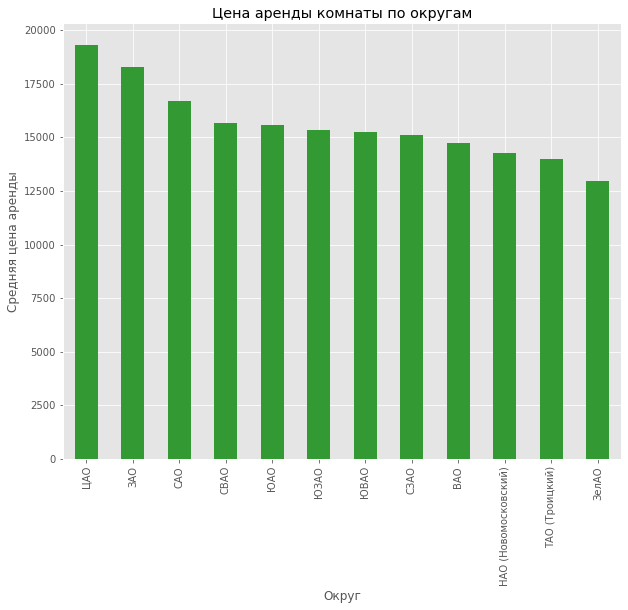

In [124]:
fig, ax = plt.subplots(figsize = (10,8))
gb_district = df.groupby('district').price.mean().sort_values(ascending = False)
gb_district.plot(kind = 'bar', ax = ax, color = '#339933')
ax.set_title("Цена аренды комнаты по округам")
ax.set_xlabel("Округ")
ax.set_ylabel("Средняя цена аренды")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

Как мы видим, налицо очевидный лидер - ЦАО. За ним с небольшим отрывом средуем ЗАО. Посмотрим, сколько это в числах.

In [125]:
df.groupby('district').price.mean().sort_values(ascending = False)

district
ЦАО                     19310.344828
ЗАО                     18300.000000
САО                     16672.727273
СВАО                    15666.666667
ЮАО                     15574.074074
ЮЗАО                    15358.208955
ЮВАО                    15250.000000
СЗАО                    15116.279070
ВАО                     14744.444444
НАО (Новомосковский)    14250.000000
ТАО (Троицкий)          14000.000000
ЗелАО                   12952.380952
Name: price, dtype: float64

В ЦАО средняя цена аренды комнаты - 19310, в ЗАО - 18300. Однако, здесь стоит учесть следующий факт - в ЦАО под видом комнат зачастую предлагают койко-место, а не комнату целиком, поэтому цена может быть занижена. Что касается остальных округов, то там средняя цена колеблется от 12952 до 16672. Поэтому мы не можем сказать, что цены в остальных округах равны. Разве что, цены в ЮАО, ЮВАО, ЮЗАО, СВАО и ЗАО приблизительно равны. НАО И ТАО мы не анализируем, так как там мало наблюдений.

Но может быть, мы пришли к таким выводам, потому что исторически комнаты в ЦАО и ЗАО больше по площади? Мы знаем, что по всем округам есть положительная связь цены аренды и площади комнаты, поэтому, проверим среднюю площадь комнат в каждом из округов, чтобы понять, связано ли дело только с местом.



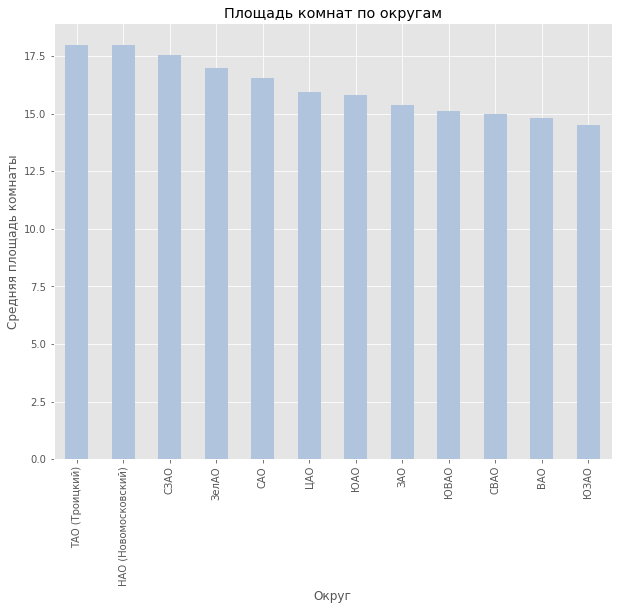

In [126]:
fig, ax = plt.subplots(figsize = (10,8))
gb_district = df.groupby('district').room_size.mean().sort_values(ascending = False)
gb_district.plot(kind = 'bar', ax = ax, color = '#B0C4DE')
ax.set_title("Площадь комнат по округам")
ax.set_xlabel("Округ")
ax.set_ylabel("Средняя площадь комнаты")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [127]:
df.groupby('district').room_size.mean().sort_values(ascending = False)

district
ТАО (Троицкий)          18.000000
НАО (Новомосковский)    18.000000
СЗАО                    17.571141
ЗелАО                   17.000000
САО                     16.551238
ЦАО                     15.950312
ЮАО                     15.807954
ЗАО                     15.376476
ЮВАО                    15.144263
СВАО                    15.007167
ВАО                     14.827778
ЮЗАО                    14.502644
Name: room_size, dtype: float64

НАО И ТАО снова не берем в расчет. Получается, самые большие комнаты - в СЗАО и ЗелАО, а ЦАО - уверенный среднячок по комнатам. Значит, дело не в больших комнатах. Проверим наши предположения группировкой по округам и переменной "цена аренды на квадратный метр комнаты"

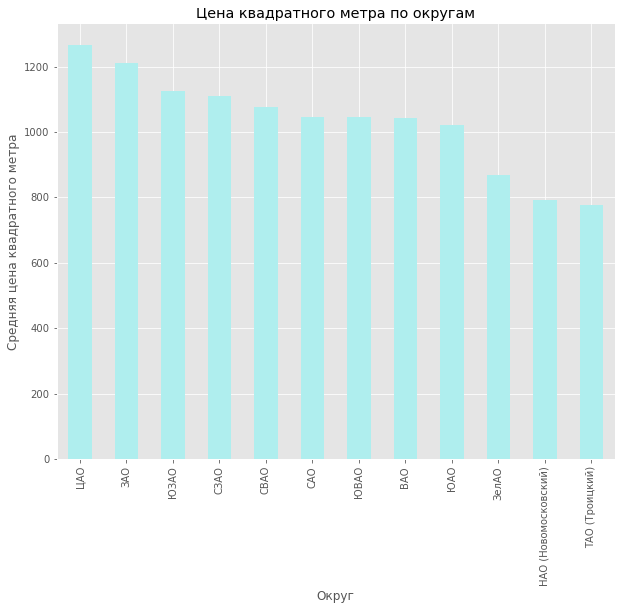

In [128]:
fig, ax = plt.subplots(figsize = (10,8))
gb_district = df.groupby('district').price_per_square.mean().sort_values(ascending = False)
gb_district.plot(kind = 'bar', ax = ax, color = '#AFEEEE')
ax.set_title("Цена квадратного метра по округам")
ax.set_xlabel("Округ")
ax.set_ylabel("Средняя цена квадратного метра")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [129]:
df.groupby('district').price_per_square.mean().sort_values(ascending = False)

district
ЦАО                     1266.243663
ЗАО                     1209.634878
ЮЗАО                    1125.360446
СЗАО                    1111.370636
СВАО                    1077.650738
САО                     1047.171724
ЮВАО                    1045.903969
ВАО                     1041.623696
ЮАО                     1021.600904
ЗелАО                    867.706722
НАО (Новомосковский)     792.013889
ТАО (Троицкий)           777.777778
Name: price_per_square, dtype: float64

**Вывод:** да, в ЦАО и правда самое дорогое жилье, и дело тут не в том, что в ЦАО самые большие комнаты. Однако, остальные округа далеко не равны друг другу в стоимости аренды: ЗАО почти равен ЦАО в цене аренды, за ним с большим отрывом следует САО, а дальше - группа округов, схожих по показателям (ЮАО, ЮВАО, ЮЗАО, СВАО и ЗАО)

## H5. Вид из окна и цены

Комнаты **с окнами во двор** стоят дороже, чем комнаты **с окном на улицу**


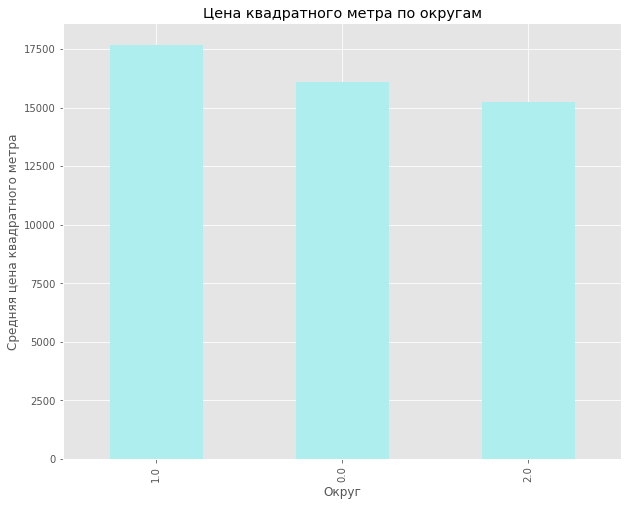

In [130]:
fig, ax = plt.subplots(figsize = (10,8))
gb_district = df.groupby('window_view').price.mean().sort_values(ascending = False)
gb_district.plot(kind = 'bar', ax = ax, color = '#AFEEEE')
ax.set_title("Цена квадратного метра по округам")
ax.set_xlabel("Округ")
ax.set_ylabel("Средняя цена квадратного метра")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [131]:
df.groupby('district').price.corr(df['window_view']).sort_values(ascending = False)

district
СЗАО                    0.362214
ЮАО                    -0.020366
ЮВАО                   -0.061639
САО                    -0.078042
ВАО                    -0.114617
СВАО                   -0.125201
ЗелАО                  -0.134548
ЗАО                    -0.260550
ЮЗАО                   -0.270870
ЦАО                    -0.329859
НАО (Новомосковский)   -0.714286
ТАО (Троицкий)               NaN
Name: price, dtype: float64

Таким образом, гипотеза отвергается, данные факты преимущественно имеют обратную связь

## H6. Количество комнат и цены

Цена аренды **не зависит** от общего **числа комнат в квартире**

Рассмотрим зависимость цены аренды квартир в каждом округе от общего числа комнат в квартире для каждого округа г. Москва. Для этого
1. Построим график распределения квартир по количеству комнат для каждого округа.

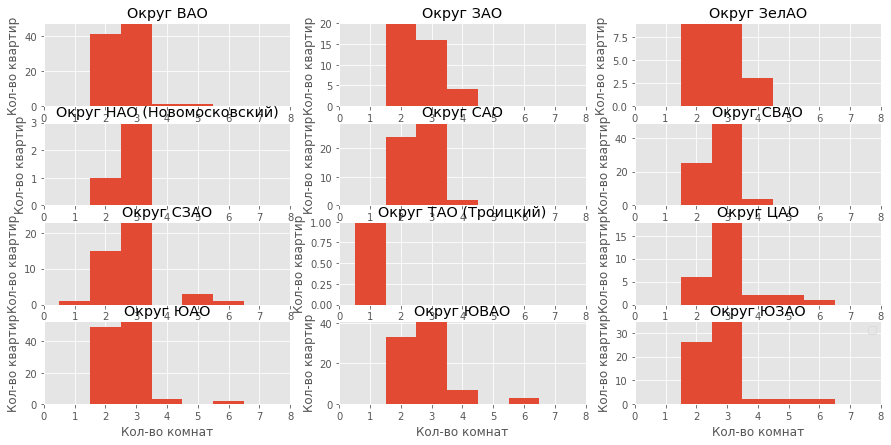

In [132]:
ds = df[['district', 'rooms_in_flat']].groupby('district')['rooms_in_flat']
fig, ax = plt.subplots(4, 3)
my_plots = zip(ds.groups.keys(), ax.flatten())
for i, (key, ax) in enumerate(my_plots):
    my_frame = ds.get_group(key).value_counts().sort_index()
    indexes = my_frame.index
    values = my_frame.values
    ax.bar(indexes, values, width=1)
    ax.axis([0, 8, 0, max(values)])
    ax.set_xlabel("Кол-во комнат")
    ax.set_ylabel("Кол-во квартир")
    ax.set_title(f'Округ {key}')
ax.legend()
plt.show()

Заметим, что во всех районах преобладают двух- и трехкомнатные квартиры. Квартиры с количеством комнат больше трех встречаются не во всех районах и являются, скорее, исключением.

2. Построим гистограммы по средней цене в каждой из категорий квартир по округам

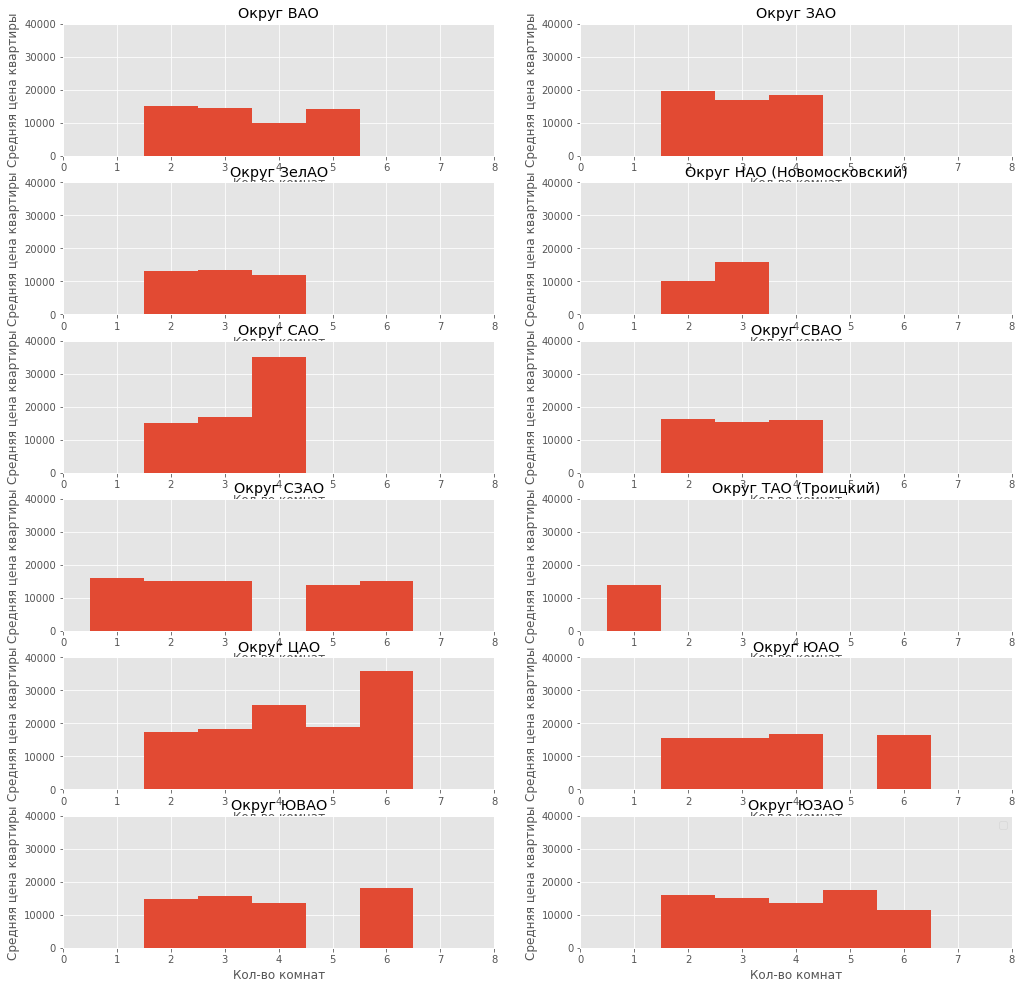

In [133]:
med = df[['district', 'price', 'rooms_in_flat']].groupby('district')
fig, ax = plt.subplots(6, 2, figsize=(17, 17))
my_plots = zip(med.groups.keys(), ax.flatten())
for i, (key, ax) in enumerate(my_plots):
    my_frame = med.get_group(key).groupby('rooms_in_flat').mean()
    indexes = my_frame.index
    values = my_frame.values
    
    ax.bar(indexes, [i[0] for i in values], width=1)
    ax.axis([0, 8, 0, 40000])
    ax.set_xlabel("Кол-во комнат")
    ax.set_ylabel("Средняя цена квартиры")
    ax.set_title(f'Округ {key}')
ax.legend()
plt.show()

3. Построим гистограммы цены на квадратный метр в каждой из категорий квартир по округам

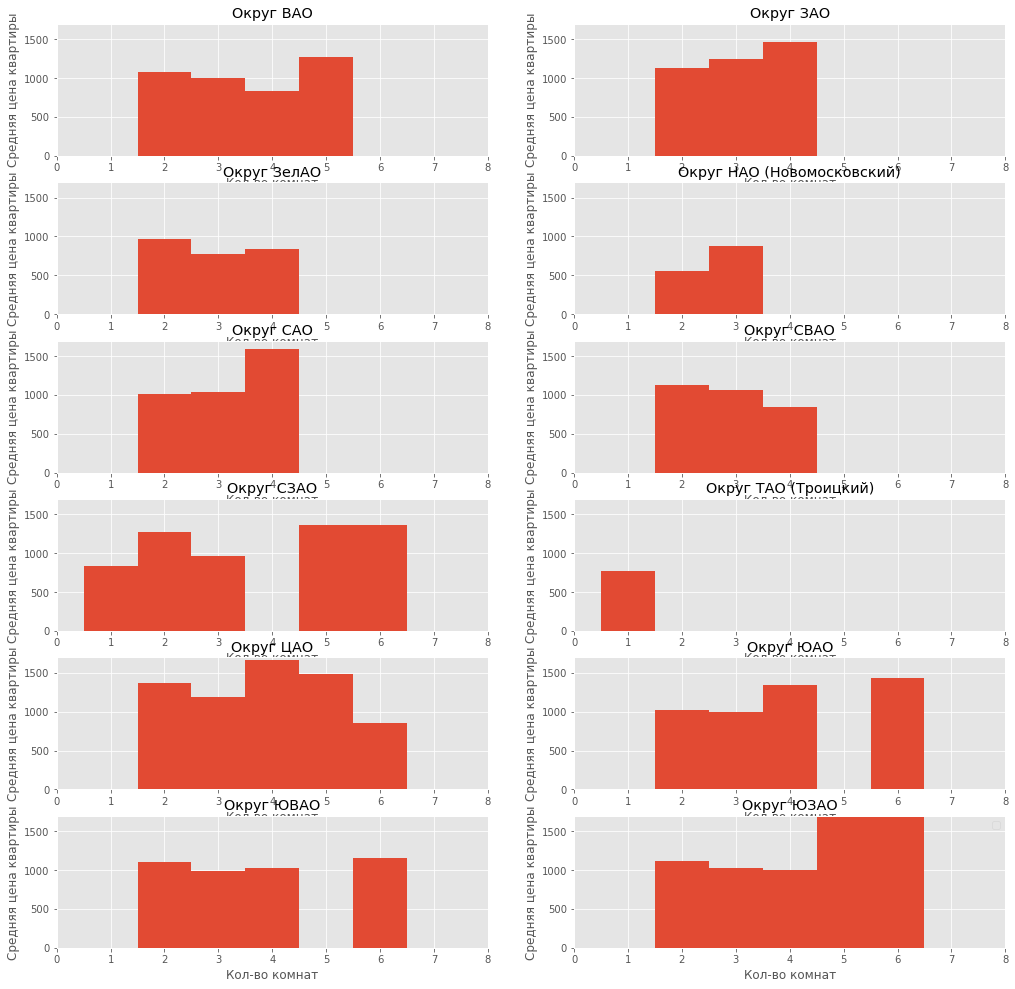

In [134]:
med = df[['district', 'price_per_square', 'rooms_in_flat']].groupby('district')
fig, ax = plt.subplots(6, 2, figsize=(17, 17))
my_plots = zip(med.groups.keys(), ax.flatten())
for i, (key, ax) in enumerate(my_plots):
    my_frame = med.get_group(key).groupby('rooms_in_flat').mean()
    indexes = my_frame.index
    values = my_frame.values
    
    ax.bar(indexes, [i[0] for i in values], width=1)
    ax.axis([0, 8, 0, 1700])
    ax.set_xlabel("Кол-во комнат")
    ax.set_ylabel("Средняя цена квартиры")
    ax.set_title(f'Округ {key}')
ax.legend()
plt.show()

Из графиков очевидно, что корреляция цены квадратного метра квартиры и количества комнат крайне слабая в большинстве районов. Однако, в квартирах НАО, САО и ЦАО наблюдается такая зависимость. Это может быть связано с тем, что в данных округах квартиры похожи по другим значимым характеристикам (качество ремонта, год постройки дома и т.д.).

Таким образом, гипотеза подтвердилась: цена аренды почти не зависит от общего числа комнат в квартире.

## H7. Размер кухни и цена

Цена аренды положительно зависит от площади кухни 

Посмотрим сначала, как дела обстоят в целом по Москве:

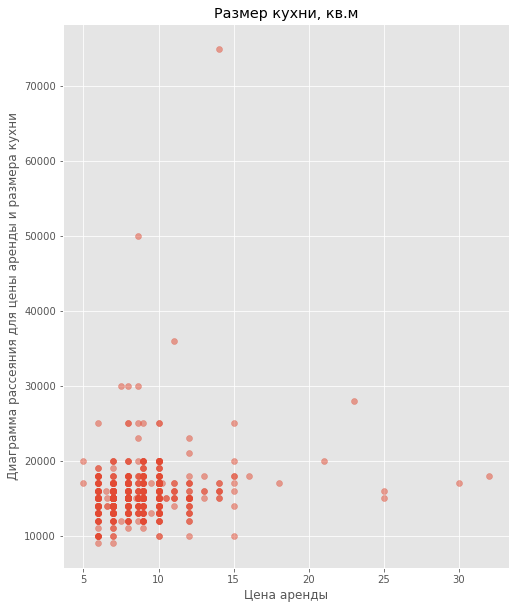

In [135]:
fig, ax = plt.subplots(figsize = (8,10))
x = df['kitchen_size']
y = df['price']
ax.set_title("Размер кухни, кв.м")
ax.set_xlabel("Цена аренды")
ax.set_ylabel("Диаграмма рассеяния для цены аренды и размера кухни");
plt.scatter(x, y,  alpha=0.5)
plt.show()

Пока что слабо похоже на линейную связь. Но может мы чего-то не видим?

In [136]:
df['price'].corr(df['kitchen_size'])

0.18947957073782876

Как мы видим, связь положительная, но слабая. Возможно, что какие-то отдельные округа с большими кухнями и недорогим жильем "перетягивают" на себя дисперсию цены, и мы получаем такое небольшое значение корреляции. Проверим, как обстоят дела в каждом отдельном округе.

In [137]:
h7_gb = df.groupby('district').price.corr(df['kitchen_size'])
h7_gb = pd.DataFrame(h7_gb)
h7_gb = h7_gb.rename(columns={'district': 'округ', 'price':'корреляция цены и размера кухни'})
h7_gb.sort_values(by = 'корреляция цены и размера кухни', ascending=False)

,корреляция цены и размера кухни
district,
ЦАО,0.427227
СЗАО,0.329527
ЗАО,0.270613
НАО (Новомосковский),0.250255
ЗелАО,0.230535
ЮВАО,0.220535
ВАО,0.219015
ЮАО,0.180508
ЮЗАО,0.170350


Ага, мы видим, что не везде ситуация одинаковая: в СЗАО и САО связь средняя, а ниже - слабая и незначительная. Значит, арендаторы в столице не однородны по тому, как они ценят кухню в разных округах

## H8. Ремонт и цена 

Качество ремонта положительно влияет на цену аренды

1. Проиллюстрируем зависимость средней цены квартир от качества ремонта.

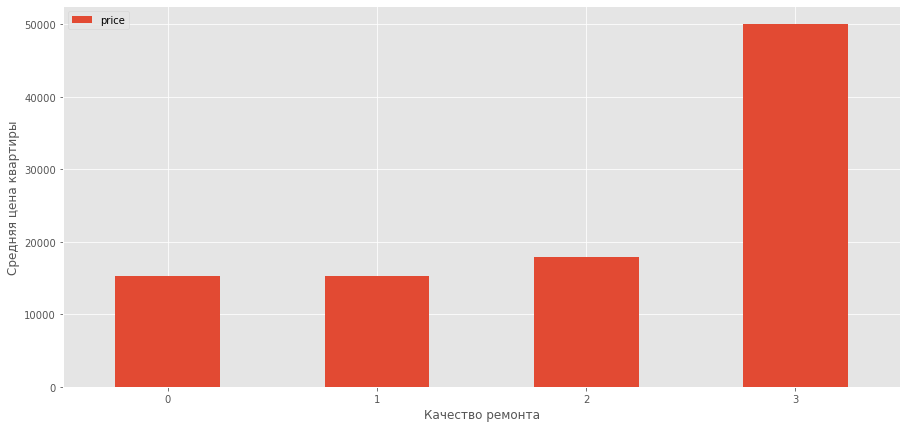

In [138]:
ds = df[['price', 'remont_scale']].groupby('remont_scale').mean()
ds.plot.bar(rot=0, xlabel='Качество ремонта', ylabel='Средняя цена квартиры');

2. Зависимость средней цены квадратного метра квартиры от качества ремонта.

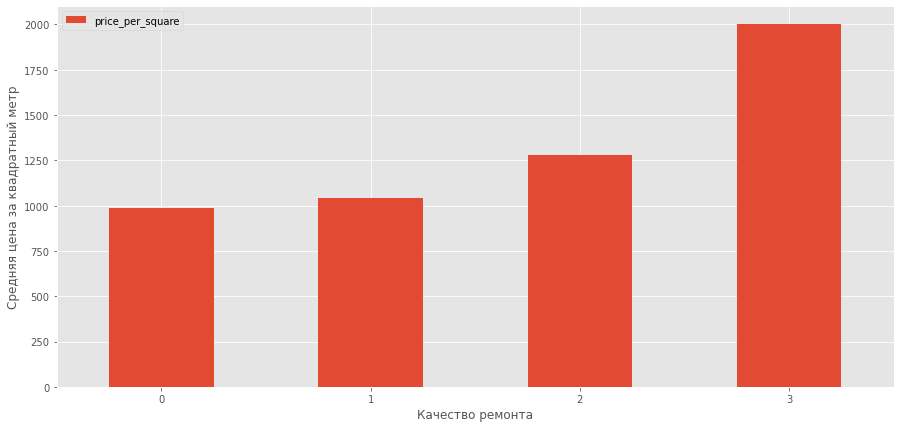

In [139]:
ds = df[['price_per_square', 'remont_scale']].groupby('remont_scale').mean()
ds.plot.bar(rot=0, xlabel='Качество ремонта', ylabel='Средняя цена за квадратный метр');

**В обоих случаях очевидна прямая зависимость цены от качества ремонта, на основе чего можно сделать вывод, что данный признак важен клиентам при выборе квартиры.**

## H9. Высота квартиры и цена

Чем выше расположена квартира, тем дороже стоиомть аренды 

Построим график зависимости средней цены квартиры, а также средней цены за квадратный метр от этажа.

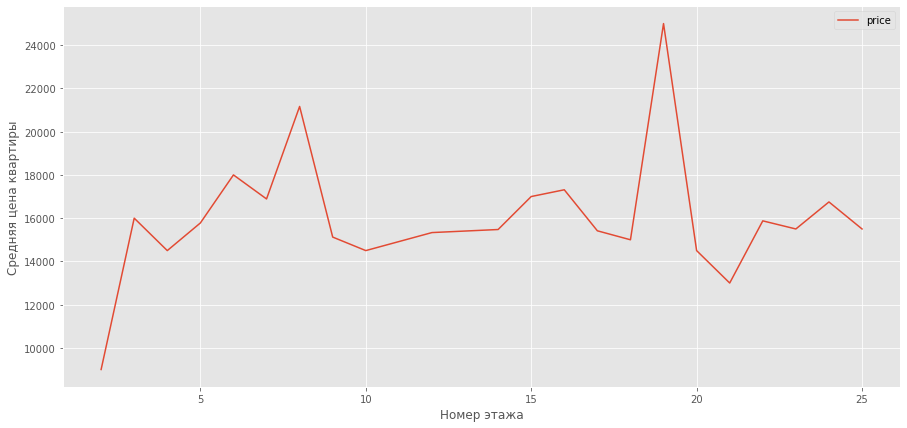

In [140]:
ds = df[['price', 'height']].groupby('height').mean()
ds.plot(rot=0, xlabel='Номер этажа', ylabel='Средняя цена квартиры');

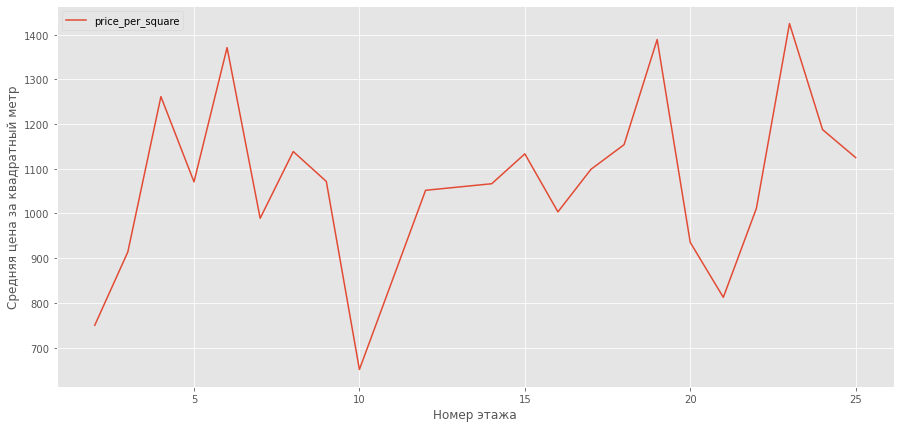

In [141]:
ds = df[['price_per_square', 'height']].groupby('height').mean()
ds.plot(rot=0, xlabel='Номер этажа', ylabel='Средняя цена за квадратный метр');

**Таким образом, мы видим, что высота квартиры не является абсолютным определющим фактором стоимости аренды.**